In [13]:
# uses insights from preprocessing_and_eda, but that notebook doesn't need to be run before this one

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
# from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

In [3]:
def make_roc_plot(y_true, y_preds):
    '''
    y_true is 1-d array
    y_preds is 1-d array
    makes and shows roc_auc plot
    '''
    fpr, tpr, _ = roc_curve(y_true, y_preds)
    auc_score = roc_auc_score(y_true, y_preds)
    plt.plot(fpr, tpr, color='darkorange', label = 'ROC curve (area = {0})'.format(auc_score) )
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(loc='lower right')
    plt.show()
    
def make_feat_imp_plot(model, model_type, data, n_bar=15, ylim=.75, imp_thrsh=.9,figsize=(12,9)):
    '''
    Makes a plot of feature importances using data
    model = model (sklearn randomforest, lightgbm, or catboost)
    model_type: str; 'sklearn-rf', 'lightgbm', or 'catboost'
    data = pool from catboost, df for others
    top_n = top n features to plot. Default is None which plots all. Can pass float as well and will calculate top_n rounded to nearest int.
    '''
    feat_names, imps = get_feature_importances_and_names(model, data, model_type)

    df = pd.DataFrame.from_dict({'feat': feat_names,
                                    'imps': imps})
    df['norm_imps'] = df['imps']/df['imps'].sum()
    df['cum_imps'] = np.cumsum(df['norm_imps'])
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    ax[0].barh(list(reversed(list(df.index[:n_bar]))), 
            df['norm_imps'].head(n_bar), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax[0].set_yticks(list(reversed(list(df.index[:n_bar]))))
    ax[0].set_yticklabels(df['feat'].head(n_bar))
    ax[0].set_xlabel('Normalized Importance')
    ax[0].set_title('Feature Importances')
    ax[1].plot(list(range(len(df))), df['cum_imps'], 'r-')
    ax[1].set_ylabel('Cumulative Feature Importance')
    ax[1].set_xlabel('Number of Features')
    ax[1].set_title('Cumulative Features')
    ax[1].set_ylim(ylim,1.01)
    fig.tight_layout()
    plt.show()
    
    return df    

In [4]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [5]:
# load in and drop fico low
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
base_loan_info.drop('fico_range_low', axis=1, inplace=True)
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')

In [19]:
to_delete = ['fico_range_low', 'grade']
cat_shap_30 = ['sub_grade',
               'term',
               'id',
               'dti',
               'loan_amount',
               'acc_open_past_24_mths',   
               'annual_inc',
               'fico_range_high',
               'total_bc_limit',
               'home_ownership', 
               'percent_bc_gt_75',
               'mort_acc', 
               'mo_sin_old_rev_tl_op',
               'int_rate',
               'addr_zip',
               'mths_since_recent_bc',
               'num_rev_tl_bal_gt_0',
               'revol_util',
               'inq_last_6_mths',
               'delinq_2_yrs',
               'bc_util', 
               'addr_state', 
               'total_rev_hi_lim',
               'purpose',
               'emp_length',
               'total_il_high_credit_limit',
               'revol_bal', 
               'mo_sin_rcnt_tl',
               'mo_sin_rcnt_rev_tl_op',
               'installment'
               ]

lgbm_shap_30 = ['sub_grade',
                'term',
                'addr_zip',
                'id',
                'acc_open_past_24_mths',
                'dti',
                'fico_range_high',
                'loan_amount',
                'annual_inc',
                'home_ownership',
                'mort_acc',
                'emp_length',
                'avg_cur_bal', 
                'num_rev_tl_bal_gt_0',
                'int_rate', 
                'total_bc_limit',
                'delinq_2_yrs',
                'mo_sin_old_rev_tl_op',
                'mths_since_recent_bc',
                'inq_last_6_mths',
                'percent_bc_gt_75',
                'bc_open_to_buy',
                'mo_sin_rcnt_tl',
                'installment',
                'purpose',
                'total_rev_hi_lim',
                'revol_bal',
                'addr_state',
                'bc_util',
               ]

In [20]:
shap_30_ft = np.array(sorted(list(set(cat_shap_30).union(set(lgbm_shap_30)))))
print(len(shap_30_ft))

32


In [21]:
np.array(sorted(list(set(cat_shap_30).union(set(lgbm_shap_30)))))

array(['acc_open_past_24_mths', 'addr_state', 'addr_zip', 'annual_inc',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2_yrs', 'dti',
       'emp_length', 'fico_range_high', 'home_ownership', 'id',
       'inq_last_6_mths', 'installment', 'int_rate', 'loan_amount',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_rev_tl_bal_gt_0',
       'percent_bc_gt_75', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_rev_hi_lim'], dtype='<U26')

shap_30_ft definitions, bank cards are atm/debit cards

acc_open_past_24_mths = number of accounts opened in 24 mths
addr_state = borrower's state
addr_zip = borrower's zip
annual_inc = self-reported annual income by borrower
avg_cur_bal = average current balance on all accounts
bc_open_to_buy = total open to buy on revolving bankcards (total remaining available credit on bankcards)
bc_util = bankcard utilization in percent
delinq_2_yrs = The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
dti = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
earliest_cr_lineElapsed = a date of earliest credit line converted to epoch time?
emp_length = Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years
fico_range_high = credit score upper bound (of only 4 diff to lower bound)
grade = LC's grade
home_ownership = The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
id = A unique LC assigned ID for the loan listing
inq_last_6_mths = The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
installment = monthly payment owed by borrower if loan originates
int_rate = loan's interest rate
loan_amount = loan amount
mo_sin_old_rev_tl_op = Months since oldest revolving account opened
mo_sin_rcnt_tl = Months since most recent account opened
mort_acc = Number of mortgage accounts
mths_since_recent_bc = Months since most recent bankcard account opened
num_rev_tl_bal_gt_0 = Number of revolving trades with balance >0
percent_bc_gt_75 = Percentage of all bankcard accounts > 75% of limit
purpose = A category provided by the borrower for the loan request
revol_bal = Total revolving credit balance
revol_util = amount of credit borrower using relative to avail revolving credit
sub_grade = LC subgrade
term = loan term
tot_hi_cred_lim = Total high credit/credit limit
total_acc = The total number of credit lines currently in the borrower's credit file
total_bc_limit = Total bankcard high credit/credit limit
total_il_high_credit_limit = Total installment high credit/credit limit

new features to try:
ratios of income/installment to high limits.

In [22]:
def transform_dates(df):
    '''
    Looks for datetime columns in the df, uses fastai's add_datepart to turn it
    into several columns (year, day, is quarter end, etc.)
    Does this inplace.
    '''
    date_cols = list(df.select_dtypes('datetime').columns)
    for col in date_cols:
        mg.add_datepart(df, col,)
        
transform_dates(base_loan_info)        

In [23]:
# added features
base_loan_info['monthly_inc'] = base_loan_info['annual_inc'] / 12
base_loan_info['dti_w_loan'] = (base_loan_info['dti'] * base_loan_info['monthly_inc'] +
                                base_loan_info['installment']) / base_loan_info['monthly_inc']
base_loan_info['delinq_to_monthly_inc'] = base_loan_info['delinq_amnt'] / \
    base_loan_info['monthly_inc']
base_loan_info['tot_cur_bal_to_monthly_inc'] = base_loan_info['tot_cur_bal'] / \
    base_loan_info['monthly_inc']
base_loan_info['loan_to_inc'] = base_loan_info['loan_amount'] / \
    base_loan_info['monthly_inc']

# see if new features helped

In [24]:
# some newly issued loans have nan for target_strict, fill with 0
eval_loan_info['target_strict'].fillna(0, inplace=True)

In [25]:
# get loans that are >= .95 maturity time, maturity paid, or status is in defaulted, charged_off, paid
done_loan_ids = eval_loan_info[(eval_loan_info['maturity_time'] >= .95) |
#                                (eval_loan_info['maturity_paid'] >= .95) |
                               (eval_loan_info['loan_status'].isin(['paid', 'charged_off', 'defaulted']))
                              ]['id'].values

In [26]:
done_loans = base_loan_info[base_loan_info['id'].isin(done_loan_ids)]
done_eval_loans = eval_loan_info[eval_loan_info['id'].isin(done_loan_ids)]

In [27]:
# make a crude test set for now
def get_split_date(df, date_column, quantile): 

    """
    https://stackoverflow.com/questions/31018622/pandas-quantile-function-for-dates
    Get the date on which to split a dataframe for timeseries splitting
    Adjusted coerce param to errors since SO is old.
    """ 

    # 1. convert date_column to datetime (useful in case it is a string) 
    # 2. convert into int (for sorting) 
    # 3. get the quantile 
    # 4. get the corresponding date
    # 5. return, pray that it works 

    quantile_date = pd.to_datetime(df[date_column], errors = 'raise').astype('int64').quantile(q=quantile)#.astype('datetime64[ns]')

    return pd.to_datetime(quantile_date)

cut_date = get_split_date(done_eval_loans, 'issue_d', .8)

In [28]:
# Catboost needs na filling, fastai can handle by itself
# done_loans.fillna(-9999, inplace=True)

In [29]:
test_ids = done_eval_loans[done_eval_loans['issue_d'] >= cut_date]['id'].values
test_df = done_loans[done_loans['id'].isin(test_ids)]
train_df = done_loans[~done_loans['id'].isin(test_ids)]

In [30]:
X = train_df
y = eval_loan_info[eval_loan_info['id'].isin(train_df['id'].values)]['target_strict']

# setup for catboost

In [120]:
if not {}:
    print('empty dict')

empty dict


In [104]:
# read the documentation on how catboost handles nan, trying autofill with -9999 (something that looks "strange") vs parameter nan_mode default (min) vs my custom handling of nans (fill median, new col to mark nan or not)
#### !!! The non-fillina NA version doesn't work, catboost throws type error. Only compare fill with -9999 and X_cat_nanfilled
X_cat_nanfilled = X.copy()
X_cat_nanfilled, _ = mg.get_medians_make_nullcols_fill_values(X_cat_nanfilled)
X_cat_9999 = X.copy()
X_cat_9999.fillna(-9999, inplace=True)

 36%|███▌      | 29/81 [00:00<00:01, 42.70it/s]

is_inc_v_joint col is likely of non-int/float dtype, filling with mode instead


 83%|████████▎ | 67/81 [00:01<00:00, 41.06it/s]

emp_length col is likely of non-int/float dtype, filling with mode instead


100%|██████████| 81/81 [00:01<00:00, 56.98it/s]


In [105]:
# Should set X_cat to be any one of the following (uncomment)
X_cat = X_cat_nanfilled
# X_cat = X_cat_9999

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb

X_train, X_validation, y_train, y_validation = train_test_split(X_cat, y, train_size=0.8, random_state=42)

X_test = test_df
y_test = eval_loan_info[eval_loan_info['id'].isin(X_test['id'].values)]['target_strict']

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [107]:
obj_cols = X_train.select_dtypes('object').columns

In [108]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

In [116]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
#     'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'nan_mode': 'Min',
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [117]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_pool, eval_set=validate_pool)

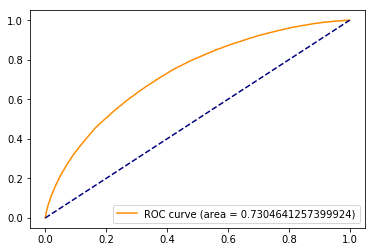

best number of trees/iterations: 499


In [118]:
# X_cat_nanfilled, typical best seen is .7304
predictions_probs = cat_model.predict_proba(X_validation)
make_roc_plot(y_validation, predictions_probs[:,1])
print('best number of trees/iterations: {0}'.format(cat_model.tree_count_))

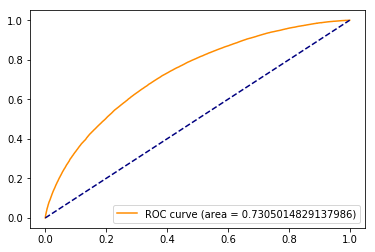

best number of trees/iterations: 494


In [54]:
# X_cat_9999, typical best seen is .7305
predictions_probs = cat_model.predict_proba(X_validation)
make_roc_plot(y_validation, predictions_probs[:,1])
print('best number of trees/iterations: {0}'.format(cat_model.tree_count_))

# check if created features are important via SHAP

In [88]:
import shap
shap.initjs()

In [89]:
cat_explainer = shap.TreeExplainer(cat_model)

In [90]:
cat_shap_values = cat_explainer.shap_values(train_pool)

The model has complex ctrs, so the SHAP values will be calculated approximately.


In [91]:
n_samp = 1000
samp_idx = np.random.choice(len(cat_shap_values), size=n_samp, replace=False)

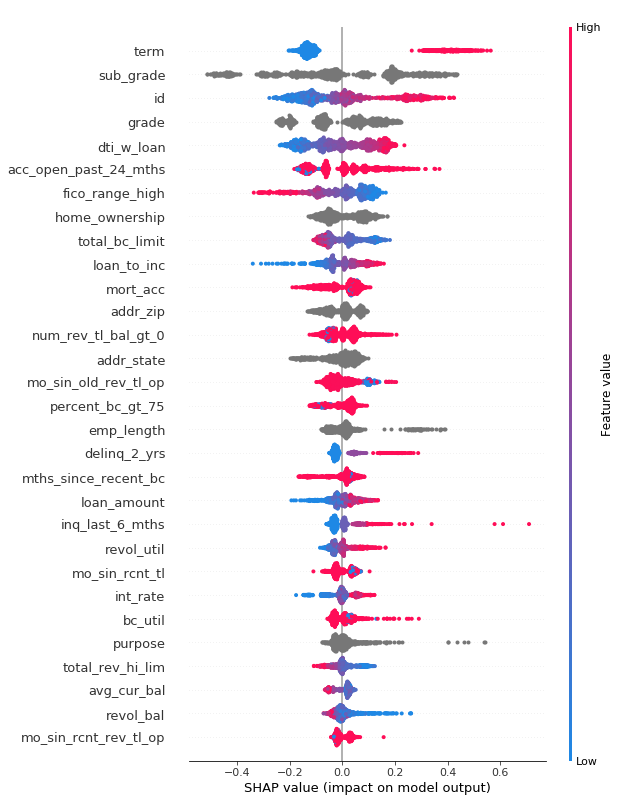

In [92]:
shap.summary_plot(cat_shap_values[samp_idx], X_train.iloc[samp_idx], max_display=30,)

# dti_w_loan and loan_to_inc have made it to high shap values

In [93]:
# export new base_loan_info
base_loan_info.to_feather(f'{data_path}/base_loan_info_w_newfeats.fth')

In [94]:
base_loan_info.shape

(2003915, 131)

# add first round of cat boost scores, see if they end up high in shap value

In [95]:
round_one_preds = cat_model.predict_proba(X_cat)

In [96]:
X_cat['round_one_preds'] = round_one_preds[:,1]

In [97]:
X_train, X_validation, y_train, y_validation = train_test_split(X_cat, y, train_size=0.8, random_state=42)

X_test = test_df
y_test = eval_loan_info[eval_loan_info['id'].isin(X_test['id'].values)]['target_strict']

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [98]:
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
#     'random_seed': 42,
    'logging_level': 'Verbose',
    'use_best_model': True,
    'task_type': 'GPU',
    'od_type': 'IncToDec'
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [99]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_pool, eval_set=validate_pool)

0:	learn: 0.7886754	test: 0.7867787	best: 0.7867787 (0)	total: 74.9ms	remaining: 1m 14s
1:	learn: 0.7886783	test: 0.7867731	best: 0.7867787 (0)	total: 162ms	remaining: 1m 21s
2:	learn: 0.7886783	test: 0.7867731	best: 0.7867787 (0)	total: 264ms	remaining: 1m 27s
3:	learn: 0.7886783	test: 0.7867731	best: 0.7867787 (0)	total: 333ms	remaining: 1m 22s
4:	learn: 0.7890130	test: 0.7877447	best: 0.7877447 (4)	total: 447ms	remaining: 1m 29s
5:	learn: 0.7889946	test: 0.7877278	best: 0.7877447 (4)	total: 538ms	remaining: 1m 29s
6:	learn: 0.7889946	test: 0.7877278	best: 0.7877447 (4)	total: 630ms	remaining: 1m 29s
7:	learn: 0.7890017	test: 0.7877222	best: 0.7877447 (4)	total: 721ms	remaining: 1m 29s
8:	learn: 0.7889974	test: 0.7877278	best: 0.7877447 (4)	total: 807ms	remaining: 1m 28s
9:	learn: 0.7889932	test: 0.7877222	best: 0.7877447 (4)	total: 897ms	remaining: 1m 28s
10:	learn: 0.7890483	test: 0.7877447	best: 0.7877447 (4)	total: 984ms	remaining: 1m 28s
11:	learn: 0.7890483	test: 0.7877673	best

93:	learn: 0.7900793	test: 0.7878464	best: 0.7878464 (93)	total: 8.09s	remaining: 1m 18s
94:	learn: 0.7901259	test: 0.7878408	best: 0.7878464 (93)	total: 8.18s	remaining: 1m 17s
95:	learn: 0.7901866	test: 0.7878860	best: 0.7878860 (95)	total: 8.28s	remaining: 1m 17s
96:	learn: 0.7901894	test: 0.7878747	best: 0.7878860 (95)	total: 8.35s	remaining: 1m 17s
97:	learn: 0.7902007	test: 0.7878634	best: 0.7878860 (95)	total: 8.46s	remaining: 1m 17s
98:	learn: 0.7902247	test: 0.7878634	best: 0.7878860 (95)	total: 8.54s	remaining: 1m 17s
99:	learn: 0.7902572	test: 0.7879142	best: 0.7879142 (99)	total: 8.62s	remaining: 1m 17s
100:	learn: 0.7902855	test: 0.7879368	best: 0.7879368 (100)	total: 8.72s	remaining: 1m 17s
101:	learn: 0.7902657	test: 0.7879425	best: 0.7879425 (101)	total: 8.81s	remaining: 1m 17s
102:	learn: 0.7902586	test: 0.7879255	best: 0.7879425 (101)	total: 8.9s	remaining: 1m 17s
103:	learn: 0.7902784	test: 0.7879538	best: 0.7879538 (103)	total: 8.97s	remaining: 1m 17s
104:	learn: 0.

185:	learn: 0.7913531	test: 0.7877786	best: 0.7879764 (138)	total: 16s	remaining: 1m 10s
186:	learn: 0.7913884	test: 0.7877899	best: 0.7879764 (138)	total: 16.1s	remaining: 1m 9s
187:	learn: 0.7913828	test: 0.7878860	best: 0.7879764 (138)	total: 16.2s	remaining: 1m 9s
188:	learn: 0.7914012	test: 0.7878690	best: 0.7879764 (138)	total: 16.2s	remaining: 1m 9s
189:	learn: 0.7914054	test: 0.7878521	best: 0.7879764 (138)	total: 16.3s	remaining: 1m 9s
190:	learn: 0.7914181	test: 0.7879086	best: 0.7879764 (138)	total: 16.4s	remaining: 1m 9s
191:	learn: 0.7914167	test: 0.7878747	best: 0.7879764 (138)	total: 16.5s	remaining: 1m 9s
192:	learn: 0.7914379	test: 0.7877843	best: 0.7879764 (138)	total: 16.6s	remaining: 1m 9s
193:	learn: 0.7914534	test: 0.7877560	best: 0.7879764 (138)	total: 16.7s	remaining: 1m 9s
194:	learn: 0.7914421	test: 0.7877617	best: 0.7879764 (138)	total: 16.7s	remaining: 1m 9s
195:	learn: 0.7914661	test: 0.7877673	best: 0.7879764 (138)	total: 16.8s	remaining: 1m 8s
196:	learn:

277:	learn: 0.7921525	test: 0.7878069	best: 0.7879764 (138)	total: 23.7s	remaining: 1m 1s
278:	learn: 0.7921779	test: 0.7878351	best: 0.7879764 (138)	total: 23.7s	remaining: 1m 1s
279:	learn: 0.7921906	test: 0.7878521	best: 0.7879764 (138)	total: 23.8s	remaining: 1m 1s
280:	learn: 0.7921963	test: 0.7878012	best: 0.7879764 (138)	total: 23.9s	remaining: 1m 1s
281:	learn: 0.7921864	test: 0.7878521	best: 0.7879764 (138)	total: 24s	remaining: 1m 1s
282:	learn: 0.7921963	test: 0.7878069	best: 0.7879764 (138)	total: 24.1s	remaining: 1m
283:	learn: 0.7922203	test: 0.7878464	best: 0.7879764 (138)	total: 24.2s	remaining: 1m
284:	learn: 0.7922203	test: 0.7877843	best: 0.7879764 (138)	total: 24.3s	remaining: 1m
285:	learn: 0.7922245	test: 0.7877730	best: 0.7879764 (138)	total: 24.4s	remaining: 1m
286:	learn: 0.7922584	test: 0.7877673	best: 0.7879764 (138)	total: 24.4s	remaining: 1m
287:	learn: 0.7922612	test: 0.7878069	best: 0.7879764 (138)	total: 24.5s	remaining: 1m
288:	learn: 0.7922415	test: 0.

369:	learn: 0.7929928	test: 0.7878916	best: 0.7879764 (138)	total: 31.2s	remaining: 53.2s
370:	learn: 0.7930126	test: 0.7878747	best: 0.7879764 (138)	total: 31.3s	remaining: 53.1s
371:	learn: 0.7930013	test: 0.7878521	best: 0.7879764 (138)	total: 31.4s	remaining: 53s
372:	learn: 0.7929914	test: 0.7878916	best: 0.7879764 (138)	total: 31.5s	remaining: 52.9s
373:	learn: 0.7930013	test: 0.7878860	best: 0.7879764 (138)	total: 31.5s	remaining: 52.8s
374:	learn: 0.7930055	test: 0.7878408	best: 0.7879764 (138)	total: 31.6s	remaining: 52.7s
375:	learn: 0.7930182	test: 0.7878860	best: 0.7879764 (138)	total: 31.7s	remaining: 52.6s
376:	learn: 0.7930493	test: 0.7878690	best: 0.7879764 (138)	total: 31.8s	remaining: 52.5s
377:	learn: 0.7930451	test: 0.7878182	best: 0.7879764 (138)	total: 31.9s	remaining: 52.4s
378:	learn: 0.7930662	test: 0.7878238	best: 0.7879764 (138)	total: 32s	remaining: 52.4s
379:	learn: 0.7930761	test: 0.7877673	best: 0.7879764 (138)	total: 32s	remaining: 52.3s
380:	learn: 0.79

461:	learn: 0.7935521	test: 0.7876205	best: 0.7879764 (138)	total: 38.9s	remaining: 45.3s
462:	learn: 0.7935577	test: 0.7876374	best: 0.7879764 (138)	total: 39s	remaining: 45.2s
463:	learn: 0.7935690	test: 0.7875922	best: 0.7879764 (138)	total: 39.1s	remaining: 45.1s
464:	learn: 0.7935916	test: 0.7876205	best: 0.7879764 (138)	total: 39.2s	remaining: 45.1s
465:	learn: 0.7935930	test: 0.7876657	best: 0.7879764 (138)	total: 39.3s	remaining: 45s
466:	learn: 0.7935958	test: 0.7876487	best: 0.7879764 (138)	total: 39.4s	remaining: 44.9s
467:	learn: 0.7936015	test: 0.7876487	best: 0.7879764 (138)	total: 39.4s	remaining: 44.8s
468:	learn: 0.7936001	test: 0.7876261	best: 0.7879764 (138)	total: 39.5s	remaining: 44.7s
469:	learn: 0.7936283	test: 0.7876261	best: 0.7879764 (138)	total: 39.6s	remaining: 44.6s
470:	learn: 0.7936382	test: 0.7875866	best: 0.7879764 (138)	total: 39.7s	remaining: 44.6s
471:	learn: 0.7936340	test: 0.7876205	best: 0.7879764 (138)	total: 39.7s	remaining: 44.5s
472:	learn: 0.

555:	learn: 0.7942978	test: 0.7875527	best: 0.7879764 (138)	total: 46.6s	remaining: 37.2s
556:	learn: 0.7942752	test: 0.7876148	best: 0.7879764 (138)	total: 46.7s	remaining: 37.2s
557:	learn: 0.7942737	test: 0.7876205	best: 0.7879764 (138)	total: 46.8s	remaining: 37.1s
558:	learn: 0.7942709	test: 0.7876261	best: 0.7879764 (138)	total: 46.9s	remaining: 37s
559:	learn: 0.7942695	test: 0.7876374	best: 0.7879764 (138)	total: 47s	remaining: 36.9s
560:	learn: 0.7942808	test: 0.7876205	best: 0.7879764 (138)	total: 47s	remaining: 36.8s
561:	learn: 0.7942822	test: 0.7876205	best: 0.7879764 (138)	total: 47.1s	remaining: 36.7s
562:	learn: 0.7942723	test: 0.7875979	best: 0.7879764 (138)	total: 47.2s	remaining: 36.7s
563:	learn: 0.7942822	test: 0.7876035	best: 0.7879764 (138)	total: 47.3s	remaining: 36.6s
564:	learn: 0.7942921	test: 0.7875753	best: 0.7879764 (138)	total: 47.4s	remaining: 36.5s
565:	learn: 0.7943147	test: 0.7876035	best: 0.7879764 (138)	total: 47.4s	remaining: 36.4s
566:	learn: 0.79

649:	learn: 0.7949615	test: 0.7873550	best: 0.7879764 (138)	total: 54.7s	remaining: 29.4s
650:	learn: 0.7949615	test: 0.7874114	best: 0.7879764 (138)	total: 54.8s	remaining: 29.4s
651:	learn: 0.7949799	test: 0.7874284	best: 0.7879764 (138)	total: 54.8s	remaining: 29.3s
652:	learn: 0.7949841	test: 0.7873719	best: 0.7879764 (138)	total: 54.9s	remaining: 29.2s
653:	learn: 0.7949785	test: 0.7873493	best: 0.7879764 (138)	total: 55s	remaining: 29.1s
654:	learn: 0.7950293	test: 0.7873267	best: 0.7879764 (138)	total: 55.1s	remaining: 29s
655:	learn: 0.7950321	test: 0.7873437	best: 0.7879764 (138)	total: 55.2s	remaining: 28.9s
656:	learn: 0.7950434	test: 0.7873098	best: 0.7879764 (138)	total: 55.3s	remaining: 28.9s
657:	learn: 0.7950547	test: 0.7873719	best: 0.7879764 (138)	total: 55.3s	remaining: 28.8s
658:	learn: 0.7950321	test: 0.7874058	best: 0.7879764 (138)	total: 55.4s	remaining: 28.7s
659:	learn: 0.7950449	test: 0.7874397	best: 0.7879764 (138)	total: 55.5s	remaining: 28.6s
660:	learn: 0.

742:	learn: 0.7955759	test: 0.7873493	best: 0.7879764 (138)	total: 1m 2s	remaining: 21.7s
743:	learn: 0.7956055	test: 0.7873606	best: 0.7879764 (138)	total: 1m 2s	remaining: 21.6s
744:	learn: 0.7956126	test: 0.7873550	best: 0.7879764 (138)	total: 1m 2s	remaining: 21.5s
745:	learn: 0.7956084	test: 0.7873493	best: 0.7879764 (138)	total: 1m 2s	remaining: 21.4s
746:	learn: 0.7956239	test: 0.7873776	best: 0.7879764 (138)	total: 1m 2s	remaining: 21.3s
747:	learn: 0.7955858	test: 0.7873098	best: 0.7879764 (138)	total: 1m 3s	remaining: 21.2s
748:	learn: 0.7956055	test: 0.7872420	best: 0.7879764 (138)	total: 1m 3s	remaining: 21.2s
749:	learn: 0.7956182	test: 0.7872363	best: 0.7879764 (138)	total: 1m 3s	remaining: 21.1s
750:	learn: 0.7956648	test: 0.7873267	best: 0.7879764 (138)	total: 1m 3s	remaining: 21s
751:	learn: 0.7956663	test: 0.7873041	best: 0.7879764 (138)	total: 1m 3s	remaining: 20.9s
752:	learn: 0.7956267	test: 0.7873098	best: 0.7879764 (138)	total: 1m 3s	remaining: 20.8s
753:	learn: 

835:	learn: 0.7961295	test: 0.7872702	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.8s
836:	learn: 0.7961366	test: 0.7873098	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.7s
837:	learn: 0.7961450	test: 0.7873437	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.6s
838:	learn: 0.7961507	test: 0.7873211	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.6s
839:	learn: 0.7961648	test: 0.7873437	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.5s
840:	learn: 0.7961676	test: 0.7873098	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.4s
841:	learn: 0.7961775	test: 0.7872476	best: 0.7879764 (138)	total: 1m 10s	remaining: 13.3s
842:	learn: 0.7961945	test: 0.7872363	best: 0.7879764 (138)	total: 1m 11s	remaining: 13.2s
843:	learn: 0.7961916	test: 0.7873041	best: 0.7879764 (138)	total: 1m 11s	remaining: 13.1s
844:	learn: 0.7961832	test: 0.7873041	best: 0.7879764 (138)	total: 1m 11s	remaining: 13.1s
845:	learn: 0.7961930	test: 0.7873380	best: 0.7879764 (138)	total: 1m 11s	remaining: 13s
8

926:	learn: 0.7967763	test: 0.7875188	best: 0.7879764 (138)	total: 1m 17s	remaining: 6.13s
927:	learn: 0.7967975	test: 0.7875414	best: 0.7879764 (138)	total: 1m 17s	remaining: 6.05s
928:	learn: 0.7968003	test: 0.7875188	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.97s
929:	learn: 0.7968074	test: 0.7875188	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.88s
930:	learn: 0.7968060	test: 0.7875527	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.8s
931:	learn: 0.7968130	test: 0.7874849	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.71s
932:	learn: 0.7968300	test: 0.7874510	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.63s
933:	learn: 0.7968300	test: 0.7874284	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.55s
934:	learn: 0.7968342	test: 0.7874227	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.46s
935:	learn: 0.7968498	test: 0.7874114	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.38s
936:	learn: 0.7968413	test: 0.7874679	best: 0.7879764 (138)	total: 1m 18s	remaining: 5.29s


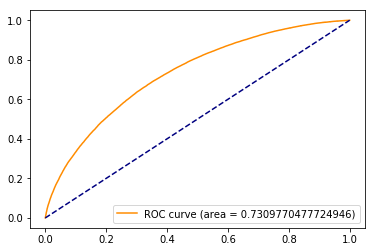

In [100]:
predictions_probs = cat_model.predict_proba(X_validation)
make_roc_plot(y_validation, predictions_probs[:,1])

# check shap to see if first round preds are high up

In [101]:
cat_explainer = shap.TreeExplainer(cat_model)

In [102]:
cat_shap_values = cat_explainer.shap_values(train_pool)

The model has complex ctrs, so the SHAP values will be calculated approximately.


In [103]:
n_samp = 1000
samp_idx = np.random.choice(len(cat_shap_values), size=n_samp, replace=False)

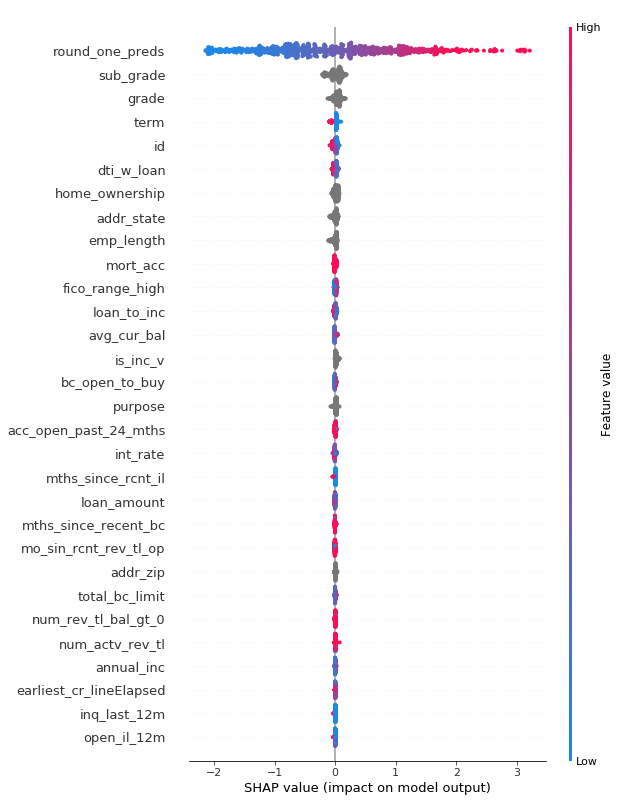

In [104]:
shap.summary_plot(cat_shap_values[samp_idx], X_train.iloc[samp_idx], max_display=30,)

#

# [seems broken atm] Check if fastai can use the new X

In [42]:
import fastai
from fastai import *
from fastai.tabular import *

In [43]:
fastai.__version__

'1.0.16.dev0'

In [51]:
X_fai = X.copy()
X_fai['target'] = y

In [52]:
tfms=[transform.FillMissing, transform.Categorify,]

In [53]:
X_fai

,pct_tl_nvr_dlq,mths_since_recent_inq,sec_app_revol_util,total_bal_il,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_actv_bc_tl,acc_open_past_24_mths,is_inc_v,annual_inc_joint,int_rate,all_util,open_act_il,sec_app_mths_since_last_major_derog,loan_amount,addr_zip,i_l_util,sec_app_open_acc,sec_app_fico_range_low,num_actv_rev_tl,total_bal_ex_mort,sec_app_chargeoff_within_12_mths,inq_last_6_mths,sec_app_fico_range_high,avg_cur_bal,is_inc_v_joint,dti_joint,installment,open_rv_12m,max_bal_bc,sec_app_inq_last_6_mths,total_cu_tl,revol_bal_joint,total_acc,pub_rec,inq_last_12m,grade,emp_length,annual_inc,num_tl_12_0dpd_2m,dti,num_rev_accts,num_bc_tl,sec_app_collections_12_mths_ex_med,tot_cur_bal,tot_coll_amt,fico_range_high,num_tl_op_past_12m,delinq_amnt,num_bc_sats,revol_util,sec_app_mort_acc,acc_now_delinq,pub_rec_bankruptcies,num_sats,num_tl_90g_dpd_24m,revol_bal,sec_app_num_rev_accts,mo_sin_old_il_acct,application_type,mo_sin_old_rev_tl_op,mths_since_rcnt_il,open_rv_24m,num_op_rev_tl,bc_open_to_buy,percent_bc_gt_75,disbursement_method,inq_fi,term,purpose,mths_since_last_delinq,mths_since_last_major_derog,bc_util,tot_hi_cred_lim,mths_since_last_record,open_il_12m,open_acc,open_acc_6m,sec_app_open_act_il,addr_state,total_il_high_credit_limit,num_tl_30dpd,mo_sin_rcnt_rev_tl_op,mths_since_recent_bc,home_ownership,num_accts_ever_12_0_ppd,chargeoff_within_12_mths,mo_sin_rcnt_tl,total_bc_limit,id,mths_since_recent_bc_dlq,sub_grade,tax_liens,mort_acc,initial_list_status,num_il_tl,delinq_2_yrs,collections_12_mths_ex_med,open_il_24m,mths_since_recent_revol_delinq,sec_app_earliest_cr_lineYear,sec_app_earliest_cr_lineMonth,sec_app_earliest_cr_lineWeek,sec_app_earliest_cr_lineDay,sec_app_earliest_cr_lineDayofweek,sec_app_earliest_cr_lineDayofyear,sec_app_earliest_cr_lineIs_month_end,sec_app_earliest_cr_lineIs_month_start,sec_app_earliest_cr_lineIs_quarter_end,sec_app_earliest_cr_lineIs_quarter_start,sec_app_earliest_cr_lineIs_year_end,sec_app_earliest_cr_lineIs_year_start,sec_app_earliest_cr_lineElapsed,earliest_cr_lineYear,earliest_cr_lineMonth,earliest_cr_lineWeek,earliest_cr_lineDay,earliest_cr_lineDayofweek,earliest_cr_lineDayofyear,earliest_cr_lineIs_month_end,earliest_cr_lineIs_month_start,earliest_cr_lineIs_quarter_end,earliest_cr_lineIs_quarter_start,earliest_cr_lineIs_year_end,earliest_cr_lineIs_year_start,earliest_cr_lineElapsed,monthly_inc,dti_w_loan,delinq_to_monthly_inc,tot_cur_bal_to_monthly_inc,loan_to_inc,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,platform,NaN,0.1189,NaN,NaN,NaN,25000.0,941xx,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,None,NaN,829.044904,NaN,NaN,NaN,NaN,NaN,42.0,0.0,NaN,B,< 1 year,85000.0,NaN,0.1948,NaN,NaN,NaN,NaN,NaN,739.0,NaN,0.0,NaN,0.521,NaN,0.0,0.0,NaN,NaN,28854.0,NaN,NaN,individual,NaN,NaN,NaN,NaN,NaN,NaN,Cash,NaN,36.0,debt_consolidation,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,CA,NaN,NaN,NaN,NaN,rent,NaN,0.0,NaN,NaN,54734,NaN,B4,0.0,NaN,f,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037,1994.0,2.0,5.0,1.0,1.0,32.0,False,True,False,False,False,False,760060800,7083.333333,0.311842,0.0,NaN,3.529412,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,0.1608,NaN,NaN,NaN,1000.0,600xx,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,35.196542,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,F,< 1 year,30000.0,NaN,0.2384,NaN,NaN,NaN,NaN,NaN,644.0,NaN,0.0,NaN,0.904,NaN,0.0,0.0,NaN,NaN,10125.0,NaN,NaN,individual,NaN,NaN,NaN,NaN,NaN,NaN,Cash,NaN,36.0,debt_consolidation,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,IL,NaN,NaN,NaN,NaN,rent,NaN,0.0,NaN,NaN,55521,NaN,F2,0.0,NaN,f,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037,2001.0,8.0,31.0,1.0,2.0,213.0,False,True,False,False,False,False,996624000,2500.000000,0.252479,0.0,NaN,0.400000,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,0.1071,NaN,NaN,NaN,7000.0,112xx,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,None,NaN,228.210882,NaN,NaN,NaN,NaN,NaN,7.0,0.0,NaN,B,< 1 year,65000.0,NaN,0.1429,NaN,NaN,NaN,NaN,NaN,709.0,NaN,0.0,NaN,0.767,NaN,0.0,0.0,N

In [54]:
data = TabularDataset.from_dataframe(df=X_fai, dep_var='target', tfms=tfms, cat_names=obj_cols, log_output=False)

TypeError: all inputs must be Index

In [55]:
%debug

> /home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py(2136)append()
   2134         for obj in to_concat:
   2135             if not isinstance(obj, Index):
-> 2136                 raise TypeError('all inputs must be Index')
   2137 
   2138         names = {obj.name for obj in to_concat}

ipdb> dir()
['obj', 'other', 'self', 'to_concat']
ipdb> obj
'pct_tl_nvr_dlq_na'
ipdb> other
'pct_tl_nvr_dlq_na'
ipdb> self
Index(['is_inc_v', 'addr_zip', 'is_inc_v_joint', 'grade', 'emp_length',
       'application_type', 'disbursement_method', 'purpose', 'addr_state',
       'home_ownership', 'sub_grade', 'initial_list_status'],
      dtype='object')
ipdb> to_concat
[Index(['is_inc_v', 'addr_zip', 'is_inc_v_joint', 'grade', 'emp_length',
       'application_type', 'disbursement_method', 'purpose', 'addr_state',
       'home_ownership', 'sub_grade', 'initial_list_status'],
      dtype='object'), 'pct_tl_nvr_dlq_na']
ipdb> u
> /home/justin/justin_tinkering/fastai/tabular/tra

ipdb> dir()
['df', 'func', 'self', 'test']
ipdb> func
<bound method FillMissing.apply_train of FillMissing(cat_names=Index(['is_inc_v', 'addr_zip', 'is_inc_v_joint', 'grade', 'emp_length',
       'application_type', 'disbursement_method', 'purpose', 'addr_state',
       'home_ownership', 'sub_grade', 'initial_list_status'],
      dtype='object'), cont_names=['pct_tl_nvr_dlq', 'mths_since_recent_inq', 'sec_app_revol_util', 'total_bal_il', 'total_rev_hi_lim', 'num_rev_tl_bal_gt_0', 'num_actv_bc_tl', 'acc_open_past_24_mths', 'annual_inc_joint', 'int_rate', 'all_util', 'open_act_il', 'sec_app_mths_since_last_major_derog', 'loan_amount', 'i_l_util', 'sec_app_open_acc', 'sec_app_fico_range_low', 'num_actv_rev_tl', 'total_bal_ex_mort', 'sec_app_chargeoff_within_12_mths', 'inq_last_6_mths', 'sec_app_fico_range_high', 'avg_cur_bal', 'dti_joint', 'installment', 'open_rv_12m', 'max_bal_bc', 'sec_app_inq_last_6_mths', 'total_cu_tl', 'revol_bal_joint', 'total_acc', 'pub_rec', 'inq_last_12m', 'annua